Model saving, loading and significant number of metrics have been taken from https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463

In [ ]:
pip install 'h5py==2.10.0' --force-reinstall


     |████████████████████████████████| 2.9 MB 8.3 MB/s 
     |████████████████████████████████| 15.7 MB 165 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
google-co

In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 66 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# TF 1.14 gives lots of warnings for deprecations ready for the switch to TF 2.0
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob

from datetime import datetime
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense, Conv2D 
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import math
import pylab
#from pylab import dist
from scipy.spatial import distance
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib
import matplotlib.gridspec as gridspec
from glob import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


From this repo https://github.com/bnsreenu/python_for_microscopists/blob/master/202_2_ways_to_load_HAM10000_data.py

In [ ]:
# Run for HAM10000 dataset

#######################################################################

!unzip gdrive/My\ Drive/Data/HAM10000.zip > /dev/null

skin_df_all = pd.read_csv('/content/HAM10000/HAM10000_metadata.csv')

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/HAM10000/', '*', '*.jpg'))}

image_dim = (128,128)

#Define the path and add as a new column
skin_df_all['path'] = skin_df_all['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_all['image'] = skin_df_all['path'].map(lambda x: np.asarray(Image.open(x).resize(image_dim)))

skin_df = skin_df_all[skin_df_all['dx'].isin(['akiec','bcc','mel','nv','bkl','df'])]

#print(skin_df['label'].value_counts())

# Array to keep all input images:
x = np.zeros((len(skin_df['image']),) + image_dim + (3,), dtype="float32")

for i, image in enumerate(skin_df['image']):
    x[i] = image

enc = LabelEncoder()

y = np.asarray(enc.fit_transform(skin_df['dx']))

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)


#######################################################################

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [ ]:
# To load in images from LFW into x_new_class_LFW and create y_new_class_LFW
###########################################################################

!unzip gdrive/My\ Drive/Data/lfw-bush.zip > /dev/null

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/lfw-bush/lfw/George_W_Bush/','*' '*.jpg'))}

image_dim = (128,128)
bush_df = pd.DataFrame(image_path.values())
bush_df.columns = ['path']
bush_df['image'] = bush_df['path'].map(lambda x: np.asarray(Image.open(x).resize(image_dim)))
x_new_class_LFW = np.zeros((len(x_test) + len(bush_df['image']),) + image_dim + (3,), dtype="float32")

for i, image in enumerate(x_test):
    x_new_class_LFW[i] = image/255

for k, image in enumerate(bush_df['image']):
    # Place input image in array:
    x_new_class_LFW[k+len(x_test)] = image/255

In [ ]:
# Check class populations
########################################################################
from collections import Counter

print(Counter(y_train).keys()) # equals to list(set(words))
print(Counter(y_train).values()) # counts the elements' frequency
########################################################################

dict_keys([5, 4, 2, 1, 0, 3])
dict_values([5367, 889, 872, 1260, 780, 270])


Run the below to augment classes and include all images in training

In [ ]:
# Load and augment all images of 7 classes, leave out VASC
###########################################################################
from sklearn.utils import shuffle

x_train_other_len = len(x_train[(y_train==5) | (y_train==2) | (y_train==4)])
                          
x_train_ak = x_train[y_train==0]

y_train_ak = y_train[y_train==0]

data_h_aug = ImageDataGenerator(horizontal_flip=True)

data_v_aug = ImageDataGenerator(vertical_flip=True)

data_h_aug.fit(x_train_ak)

data_v_aug.fit(x_train_ak)

for x_ak_h, y_ak_h in data_v_aug.flow(x_train_ak, y_train_ak, batch_size=len(x_train_ak)):
  break

for x_ak_v, y_ak_v in data_h_aug.flow(x_train_ak, y_train_ak, batch_size=len(x_train_ak)):
  break

x_train_bcc = x_train[y_train==1]

y_train_bcc = y_train[y_train==1]

data_h_aug.fit(x_train_bcc)

data_v_aug.fit(x_train_bcc)

for x_bcc_h, y_bcc_h in data_v_aug.flow(x_train_bcc, y_train_bcc, batch_size=len(x_train_bcc)):
  break

for x_bcc_v, y_bcc_v in data_h_aug.flow(x_train_bcc, y_train_bcc, batch_size=len(x_train_bcc)):
  break

df_images_x = x_train[y_train == 3]

df_images_y = y_train[y_train == 3]

data_h_aug = ImageDataGenerator(horizontal_flip=True)

data_v_aug = ImageDataGenerator(vertical_flip=True)

data_h_aug.fit(df_images_x)

data_v_aug.fit(df_images_x)

for x_df_h, y_df_h in data_v_aug.flow(df_images_x, df_images_y, batch_size=len(df_images_x)):
  break

for x_df_v, y_df_v in data_h_aug.flow(df_images_x, df_images_y, batch_size=len(df_images_x)):
  break

new_x_train_length = (x_train_other_len +  len(x_train_ak)+len(x_ak_h)+len(x_ak_v) + len(x_train_bcc)+len(x_bcc_h)+len(x_bcc_v) + len(df_images_x) +
                      len(x_df_h) + len(x_df_v))

x_train_new = np.zeros((new_x_train_length,) + image_dim + (3,), dtype="float32")

for i, image in enumerate(x_train[(y_train==5) | (y_train==2) | (y_train==4)]):
    # Place input image in array:
    x_train_new[i] = image

for l, image in enumerate(x_train_ak):
    # Place input image in array:
    x_train_new[x_train_other_len+l] = image

for n, image in enumerate(x_train_bcc):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+n] = image

for o, image in enumerate(df_images_x):
    # Place input image in array:
     x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+o] = image

for p, image in enumerate(x_df_h):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+p] = image

for q, image in enumerate(x_df_v):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+len(x_df_h)+q] = image

for r, image in enumerate(x_bcc_h):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+len(x_df_h)+len(x_df_v)+r] = image

for s, image in enumerate(x_bcc_v):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+len(x_df_h)+len(x_df_v)+len(x_bcc_h)+s] = image

for t, image in enumerate(x_ak_h):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+len(x_df_h)+len(x_df_v)+len(x_bcc_h)+len(x_bcc_v)+t] = image

for u, image in enumerate(x_ak_v):
    # Place input image in array:
    x_train_new[x_train_other_len+len(x_train_ak)+len(x_train_bcc)+len(df_images_x)+len(x_df_h)+len(x_df_v)+len(x_bcc_h)+len(x_bcc_v)+len(x_ak_h)+u] = image


arrays = (y_train[(y_train==5) | (y_train==2) | (y_train==4)], y_train_ak, y_train_bcc, df_images_y, y_df_h, y_df_v,y_bcc_h,y_bcc_v,y_ak_h,y_ak_v)

y_train_new = np.concatenate(arrays)

x_train, y_train = shuffle(x_train_new,y_train_new)


#####################################################################################

In [ ]:
lst = [skin_df, skin_df_all]
del lst 

In [ ]:
from collections import Counter

print(Counter(y_train).keys()) # equals to list(set(words))
print(Counter(y_train).values()) # counts the elements' frequency

dict_keys([5, 1, 4, 0, 2, 3])
dict_values([5367, 1260, 889, 780, 872, 270])


In [ ]:
# To load in non-cancerous images into x_new_class
###########################################################################

skin_df_vasc = skin_df_all[skin_df_all['dx'].isin(['vasc'])]

x_new_class = np.zeros((len(x_test) + len(skin_df_vasc['image']),) + image_dim + (3,), dtype="float32")

for l, image in enumerate(x_test):
    # Place input image in array:
    x_new_class[l] = image/255

    
for k, image in enumerate(skin_df_vasc['image']):
    # Place input image in array:
    x_new_class[k+len(x_test)] = image/255



############################################################################

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train_w = x_train.shape[1] 
x_train_h = x_train.shape[2]
x_train_c = x_train.shape[3]
x_test_w = x_test.shape[1]
x_test_h = x_test.shape[2]
x_test_c = x_test.shape[3]

x_train_w_h_c = x_train_w * x_train_h * x_train_c 
x_test_w_h_c = x_test_w * x_test_h * x_test_c

x_train = x_train/255.
x_test = x_test/255.

num_classes = len(np.unique(y_train))
print(num_classes)


(9438, 128, 128, 3)
(1975, 128, 128, 3)
(9438,)
(1975,)
6


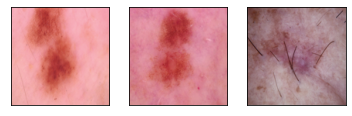

In [ ]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(examples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
plot_triplets([x_test[0], x_train[1], x_train[2]])

Below from this repo: https://github.com/omoindrot/tensorflow-triplet-loss

In [ ]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

Below from this repo: https://github.com/ma1112/keras-triplet-loss/blob/master/keras_triplet_loss.ipynb

In [ ]:
from keras import backend as K

def keras_batch_all_triplet_loss(labels, y_pred):
  # As omoindrot's loss functions expects the labels to have shape (batch_size,), labels are flattaned.
  # Before flattening, they have shape (batch_size,1).
  
  labels = K.flatten(labels)
  return batch_all_triplet_loss(labels, y_pred, margin = 0.2)

def keras_batch_hard_triplet_loss(labels, y_pred):
  # As omoindrot's loss functions expects the labels to have shape (batch_size,), labels are flattaned.
  # Before flattening, they have shape (batch_size,1).
  
  labels = K.flatten(labels)
  return batch_hard_triplet_loss(labels, y_pred, margin = 0.2)

In [ ]:
def create_SNN(embedding_model):

    input = tf.keras.layers.Input(shape=(x_train_w,x_train_h, x_train_c))

    output = embedding_model(input)

    siamese_net = tf.keras.models.Model([input], 
                                        output)
    siamese_net.summary()
    
    return siamese_net

Run below to use EmbeddingNet model

In [ ]:
from tensorflow.keras.layers import PReLU
from keras.initializers import Constant

# Create EmbeddingNet model:
def create_embedding_model(emb_size):

  model = Sequential()

  # The first conv layer with 32 kernels of 3*3 receiving an input of 32*32*3:
  model.add(Conv2D(32, (5, 5), padding='same', input_shape=(x_train_w, x_train_h, x_train_c)))

  model.add(PReLU(alpha_initializer=Constant(value=0.25)))

  # Max pooling layer with a kernel of 2*2 and a stride of 2:
  model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

  # Conv layer with 64 kernels of 3*3:
  model.add(Conv2D(64, (5, 5), padding='same'))

  model.add(PReLU(alpha_initializer=Constant(value=0.25)))

  # Max pooling layer with a kernel of 2*2 and a stride of 2:
  model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

  # The feature maps are flattened at this point to be passed into fully-connected layers:
  model.add(Flatten())

  # Fully-connected layers leading to embedding layer of length emb_size
  model.add(Dense(256))

  model.add(PReLU(alpha_initializer=Constant(value=0.25)))

  model.add(Dense(256))

  model.add(PReLU(alpha_initializer=Constant(value=0.25)))

  model.add(Dense(emb_size))

  model.add(Lambda(lambda  x: K.l2_normalize(x,axis=1)))

  return model

Run below for InceptionResNet-V2 model

In [ ]:
# Create InceptionResNetV2 embedding layer - sequential

def create_embedding_model(emb_size):

  model = Sequential()
  model.add(tf.keras.applications.InceptionResNetV2(input_shape = (x_train_w,x_train_h, x_train_c),
                                                 weights = 'imagenet',
                                                 include_top=False, pooling='avg'))
  model.add(Flatten())
  model.add(Dense(emb_size, activation = 'linear'))
  model.add(Lambda(lambda  x: K.l2_normalize(x,axis=1)))

  return model

Run below for ResNet-152 model

In [ ]:
# Create ResNet152 embedding layer - sequential

def create_embedding_model(emb_size):

  model = Sequential()
  model.add(tf.keras.applications.ResNet152(input_shape = (x_train_w,x_train_h, x_train_c),
                                                 weights = 'imagenet',
                                                 include_top=False, pooling='avg'))
  model.add(Flatten())
  model.add(Dense(emb_size, activation = 'linear'))
  model.add(Lambda(lambda  x: K.l2_normalize(x,axis=1)))

  return model
  

make_confusion_matrix from this repo: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

In [ ]:
def compute_dist(a,b):
    return np.linalg.norm(a-b)

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all imgs with current embedding network
    embeddings = network.predict(X)
    
    k = 0
    
    # For each img in the evaluation set
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tSAME".format(i,j,probs[k],k, Y[i], Y[j]))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : {2}\tDIFF".format(i,j,probs[k],k, Y[i], Y[j]))
                k += 1
    return probs, y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_interdist(network, epochs):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(num_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(epochs))
    ax.set_ylim([0,5])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(num_classes))

    plt.show()
    
    
def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (num_classes,num_classes) 
    '''
    res = np.zeros((num_classes,num_classes))
    
    ref_images = np.zeros((num_classes, x_test_w, x_test_h, x_test_c))
    
    #generates embeddings for reference images
    for i in range(num_classes):
        ref_images[i,:] = x_test[i]
    
    ref_embeddings = network.predict(ref_images)
    
    for i in range(num_classes):
        for j in range(num_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : result of the similarity scores with the basic images => (N)
    
    '''
    nbimages = images.shape[0]
    
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((num_classes,x_test_w, x_test_h, x_test_c))
    for i in range(num_classes):
        images_at_this_index_are_of_class_i = np.squeeze(np.where(y_test == i))
        ref_images[i,:] = x_test[images_at_this_index_are_of_class_i[refidx]]
        
        
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        # Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,num_classes+1,1)
        plt.axis("off")
        plotidx = 2
            
        # Draw this image    
        plt.imshow(np.reshape(images[i], (x_train_w, x_train_h, x_train_c)),vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(num_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,num_classes+1,plotidx)
            plt.axis("off")
            plt.imshow(np.reshape(ref_images[ref, :], (x_train_w, x_train_h, x_train_c)),vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

def generate_prototypes(x_data, y_data, embedding_model):

    # create array of unique values in an array
    classes = np.unique(y_data)
    prototypes = {}

    for c in classes:
        #c = classes[0]
        # Find all images of the chosen test class
        locations_of_c = np.where(y_data == c)[0]

        imgs_of_c = x_data[locations_of_c]

        # calculate the embeddings of all x_data values of each class then calculate the median of them

        imgs_of_c_embeddings = embedding_model.predict(imgs_of_c)

        # Get the median of the embeddings to generate a prototype for the class (reshaping for PCA)
        prototype_for_c = np.median(imgs_of_c_embeddings, axis = 0).reshape(1, -1)
        # Add it to the prototype dict
        prototypes[c] = prototype_for_c
        
    return prototypes
         
def test_one_shot_prototypes(network, sample_embeddings):
    distances_from_img_to_test_against = []
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
    # As the correct img will be at distances_from_img_to_test_against index 0 (sample_imgs index 1),
    # If the smallest distance in distances_from_img_to_test_against is at index 0, 
    # we know the one shot test got the right answer
    is_min = distances_from_img_to_test_against[0] == min(distances_from_img_to_test_against)
    is_max = distances_from_img_to_test_against[0] == max(distances_from_img_to_test_against)

    # int of boolean TRUE is 1 and 0 for FALSE. Will return 1 if both conditions are satisfied.
    return int(is_min and not is_max)
    
def n_way_accuracy_prototypes(n_val, n_way, network):
    num_correct = 0
    
    for val_step in range(n_val):
        num_correct += load_one_shot_test_batch_prototypes(n_way, network)
        
    accuracy = num_correct / n_val * 100
        
    return accuracy

def load_one_shot_test_batch_prototypes(n_way, network):
    
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    # selects n_way labels at random from labels 1-7
    labels = np.random.choice(labels, size = n_way, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    
    sample_embeddings = []
    # Get the anchor image embedding
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
 
    sample_embeddings.append(positive_prototype)
    
    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
                
    correct = test_one_shot_prototypes(network, sample_embeddings)

    return correct


def visualise_n_way_prototypes(n_samples, network):
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    labels = np.random.choice(labels, size = n_samples, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Get another image idx that we know is of the test class for the sample set
    label_sample_img_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    label_sample_img = np.expand_dims(x_test[label_sample_img_idx],axis=0)
    
    # Make the first img in the sample set the chosen test image, the second the other image
    sample_imgs = np.empty((0, x_test_w_h_c))
    sample_imgs = np.append(sample_imgs, img_of_label, axis=0)
    sample_imgs = np.append(sample_imgs, label_sample_img, axis=0)
    
    sample_embeddings = []
    
    # Get the anchor embedding image
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
    sample_embeddings.append(positive_prototype)

    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
        
        # Find all images of the other class
        imgs_of_other_label = np.where(y_test == other_label)[0]
        # Randomly select an image of the selected class, return it's index
        another_sample_img_idx = random.choice(imgs_of_other_label)
        # Expand the array at the selected index into useable images
        another_sample_img = np.expand_dims(x_test[another_sample_img_idx],axis=0)
        # Add the image to the support set
        sample_imgs = np.append(sample_imgs, another_sample_img, axis=0)
    
    distances_from_img_to_test_against = []
    
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
        
    # + 1 as distances_from_img_to_test_against doesn't include the test image
    min_index = distances_from_img_to_test_against.index(min(distances_from_img_to_test_against)) + 1
    
    return sample_imgs, min_index

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          include_new=True,
                          font_size=18):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    classpop_cf = cf/cf.sum(axis=1, keepdims=True)

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        #group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = ["{0:.2%}".format(value) for value in classpop_cf.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            #stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
            stats_text = "\n\nTop-1 Accuracy={:0.2%}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    if include_new:
      disease_labels = ['AK','BCC','BKL','DF','MM','NEV','NEW']
    else:
      disease_labels = ['AK','BCC','BKL','DF','MM','NEV']

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    hm = sns.heatmap(classpop_cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=disease_labels,yticklabels=disease_labels, 
                     annot_kws= {"fontsize":font_size})

    hm.set_yticklabels(hm.get_yticklabels(), rotation=30, fontsize = font_size)
    hm.set_xticklabels(hm.get_yticklabels(), fontsize = font_size)  

    if xyplotlabels:
        plt.ylabel('True label',fontsize=15)
        plt.xlabel('Predicted label' + stats_text,fontsize=15)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontdict={'fontsize': 15})

def evaluate(embedding_model, epochs = 0):
    probs,yprob = compute_probs(embedding_model, x_test[:500, :], y_test[:500])
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)
    draw_interdist(embedding_model, epochs)

    for i in range(3):
        DrawTestImage(embedding_model, np.expand_dims(x_train[i],axis=0))

Define name of model or load previous 

Generating embedding model... 


Generating SNN... 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 128)               17716800  
Total params: 17,716,800
Trainable params: 17,716,800
Non-trainable params: 0
_________________________________________________________________

Evaluating the model without training for a baseline...



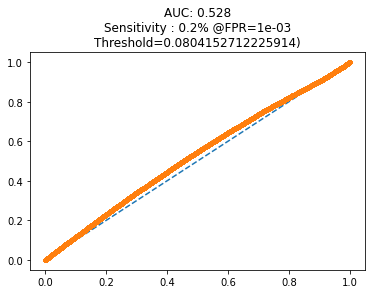

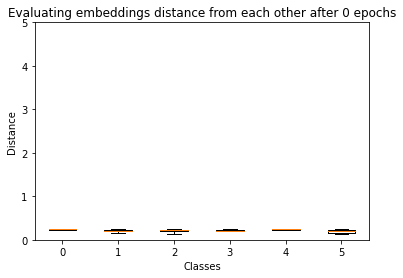

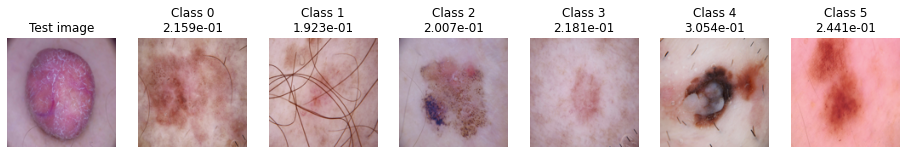

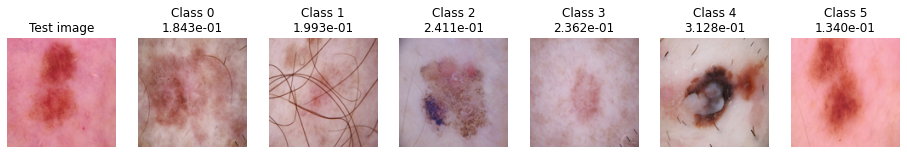

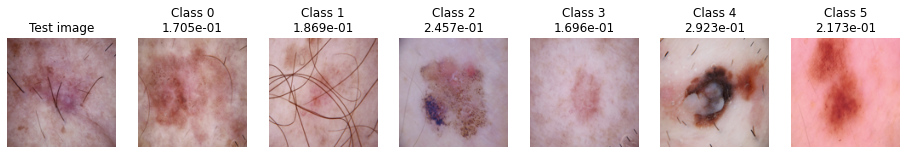

In [ ]:
# Hyperparams
batch_size = 64
epochs = 20
alpha = 0.2
lr = 0.0001
optimiser = 'Adam'
emb_size = 128

with tf.device("/gpu:0"):
    # Create the embedding model
    print("Generating embedding model... \n")
    embedding_model = create_embedding_model(emb_size)
    
    print("\nGenerating SNN... \n")
    # Create the SNN
    siamese_net = create_SNN(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss=keras_batch_all_triplet_loss, optimizer= optimiser_obj)

    # Store visualisations of the embeddings using PCA for display next to "after training" for comparisons
    num_vis = 500 # Take only the first num_vis elements of the test set to visualise
    embeddings_before_train = embedding_model.predict(x_test[:num_vis, :])
    pca = PCA(n_components=2)
    decomposed_embeddings_before = pca.fit_transform(embeddings_before_train)


# Display evaluation the untrained model
print("\nEvaluating the model without training for a baseline...\n")
evaluate(embedding_model)

# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOGDIR",dt)

## Use a custom non-dt name:
name = "test_embeddingnet-6-augmented-classes-all-images-batchall"
logdir = os.path.join("/content/gdrive/MyDrive/HAM10000_SNN",name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            #if self.verbose == 1:
                #print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'alpha' : alpha, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : emb_size
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)


def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)

    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [int(file.split("-")[1].split(".h5")[0]) for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = str(emb_model_files_epoch_nums[-1]).zfill(2)

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if ("-" + highest_epoch_num + "-") not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file")
    for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
        for file in model_file_list:
            os.remove(os.path.join(model_dir, file))

In [ ]:
print("Starting training process!")
print("-------------------------------------")

siamese_net.compile(loss=keras_batch_all_triplet_loss, optimizer= optimiser_obj)

siamese_history = siamese_net.fit(
    x_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks, 
    workers = 0, 
    validation_data = (x_test,y_test))

print("-------------------------------------")
print("Training complete.")


Starting training process!
-------------------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9438 samples, validate on 1975 samples
Epoch 1/20
9408/9438 [============================>.] - ETA: 0s - loss: 0.2518
Epoch 00001: val_loss improved from inf to 0.59029, saving model to /content/gdrive/MyDrive/HAM10000_SNN/test_resnet-6-augmented-classes-all-images-batchall-new_code_test/snn_model-01-0.59.h5
9438/9438 [==============================] - 89s 9ms/sample - loss: 0.2515 - val_loss: 0.5903
Epoch 2/20
9408/9438 [============================>.] - ETA: 0s - loss: 0.1811
Epoch 00002: val_loss did not improve from 0.59029
9438/9438 [==============================] - 55s 6ms/sample - loss: 0.1809 - val_loss: 0.5990
Epoch 3/20
9408/9438 [============================>.] - ETA: 0s - loss: 0.1507
Epoch 00003: val_loss did not improve from 0.59029
9438/9438 [==============================] - 55s 6ms/sample - loss: 0.1505

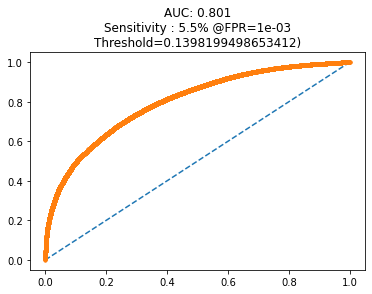

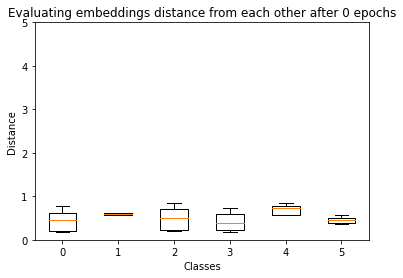

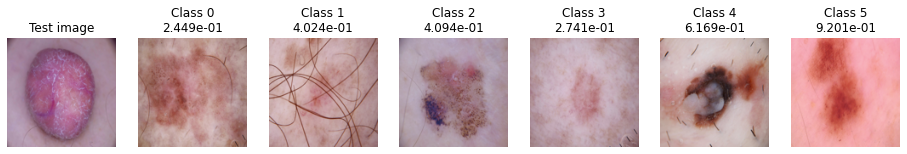

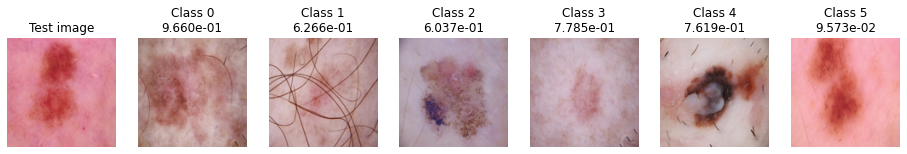

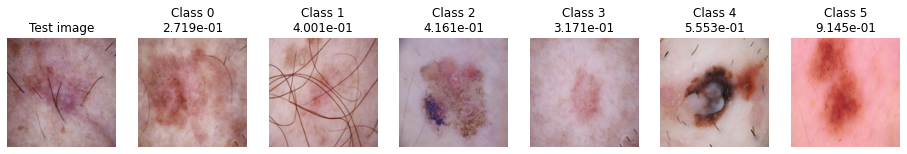

In [ ]:
# Load version of model with lowest val_loss from directory
#########################################################################

def json_to_dict(json_src):
    with open(json_src, 'r') as j:
        return json.loads(j.read())
      
## Load in best trained SNN and emb model

# The best performing model weights has the higher epoch number due to only saving the best weights
highest_epoch = 0
dir_list = os.listdir(logdir)

for file in dir_list:
    if file.endswith(".h5"):
        epoch_num = int(file.split("-")[1].split(".h5")[0])
        if epoch_num > highest_epoch:
            highest_epoch = epoch_num

# Find the embedding and SNN weights src for the highest_epoch (best) model
for file in dir_list:
    # Zfill ensure a leading 0 on number < 10
    if ("-" + str(highest_epoch).zfill(2)) in file:
        if file.startswith("emb"):
            embedding_weights_src = os.path.join(logdir, file)
        elif file.startswith("snn"):
            snn_weights_src = os.path.join(logdir, file)

hyperparams = os.path.join(logdir, "hyperparams.json")
snn_config = os.path.join(logdir, "siamese_config.json")
emb_config = os.path.join(logdir, "embedding_config.json")

snn_config = json_to_dict(snn_config)
emb_config = json_to_dict(emb_config)

# json.dumps to make the dict a string, as required by model_from_json
loaded_snn_model = model_from_json(json.dumps(snn_config))
loaded_snn_model.load_weights(snn_weights_src)

loaded_emb_model = model_from_json(json.dumps(emb_config))
loaded_emb_model.load_weights(embedding_weights_src)

prototypes = generate_prototypes(x_test, y_test, loaded_emb_model)
# Create representations of the embedding space via PCA
embeddings_after_train = loaded_emb_model.predict(x_test[:500, :])
pca = PCA(n_components=2)
decomposed_embeddings_after = pca.fit_transform(embeddings_after_train)

evaluate(loaded_emb_model)

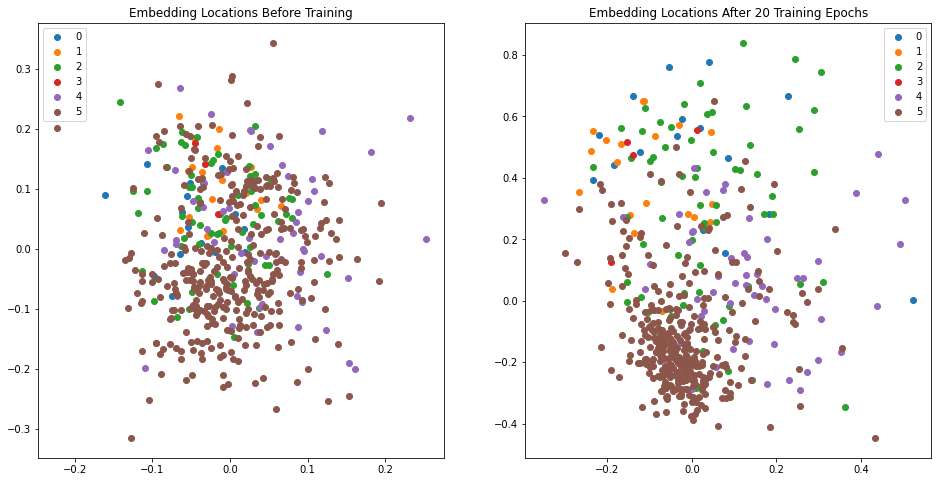

In [ ]:
# Create PCA plots before and after training of loaded model
##########################################################################

step = 1 # Step = 1, take every element

dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_test))

decomposed_embeddings_after = pca.fit_transform(embeddings_after_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    
    y_test_labels = y_test[:num_vis]
    
    decomposed_embeddings_class_before = decomposed_embeddings_before[y_test_labels == label]
    decomposed_embeddings_class_after = decomposed_embeddings_after[y_test_labels == label]
    
    plt.subplot(1,2,1)
    plt.scatter(decomposed_embeddings_class_before[::step, 1], decomposed_embeddings_class_before[::step, 0], label=str(label))
    plt.title('Embedding Locations Before Training')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class_after[::step, 1], decomposed_embeddings_class_after[::step, 0], label=str(label))
    plt.title('Embedding Locations After %d Training Epochs' % epochs)
    plt.legend()

plt.show()

In [ ]:
test_set = loaded_emb_model.predict(x_test)
train_set = loaded_emb_model.predict(x_train)

In [ ]:
# Compute top-1 and top-3 accuracy 
###############################################################################

knn = KNeighborsClassifier(n_neighbors=26, weights='distance',metric='euclidean')
knn.fit(train_set, y_train)
y_pred_knn = knn.predict(test_set)
y_pred_knn_probs = knn.predict_proba(test_set)
print("Top-1 Accuracy: ", accuracy_score(y_pred_knn,y_test))
print("Top-3 Accuracy: ",top_k_accuracy_score(y_test, y_pred_knn_probs, k=3, normalize=True))

###############################################################################

Top-1 Accuracy:  0.7139240506329114
Top-3 Accuracy:  0.9118987341772152


In [ ]:
# Compute sensitivity and specificity per class
#######################################################################

cm = confusion_matrix(y_test,y_pred_knn)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
print('Sensitivity:',TP/(TP+FN))
print('Sensitivity:',TN/(TN+FP)) 

########################################################################

Sensitivity: [0.62686567 0.81914894 0.55506608 0.48       0.51339286 0.93423019]
Sensitivity: [0.98060797 0.97076023 0.95823799 0.99589744 0.96287836 0.81946625]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_knn, target_names=['AK','BCC','BKL','DF','MM','NEV'], digits=4))

              precision    recall  f1-score   support

          AK     0.5316    0.6269    0.5753        67
         BCC     0.5833    0.8191    0.6814        94
         BKL     0.6332    0.5551    0.5915       227
          DF     0.6000    0.4800    0.5333        25
          MM     0.6389    0.5134    0.5693       224
         NEV     0.9158    0.9342    0.9249      1338

    accuracy                         0.8213      1975
   macro avg     0.6505    0.6548    0.6460      1975
weighted avg     0.8190    0.8213    0.8179      1975



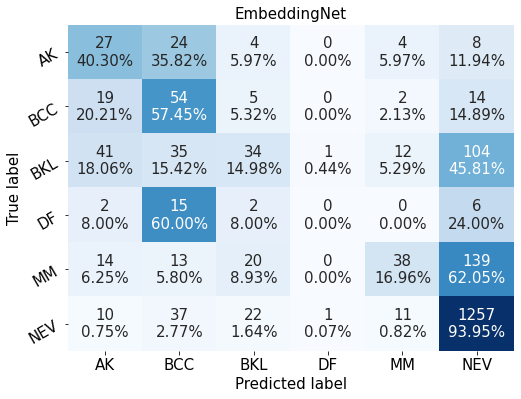

In [ ]:
# Make confusion matrix 
########################################################################
cm = confusion_matrix(y_test,y_pred_knn)
#make_confusion_matrix(cm, figsize=(8,6), cbar=False, include_new = False)
make_confusion_matrix(cm, figsize=(8,6), 
                      cbar=False, 
                      include_new = False, 
                      percent=True, 
                      font_size = 15, 
                      sum_stats=False, 
                      title ="EmbeddingNet" )

In [ ]:
# Create test embeddings with new class

test_set_new_class = loaded_emb_model.predict(x_new_class)

y_new_class = np.append(y_test,np.full(
  shape=len(skin_df_vasc['image']),
  fill_value=num_classes,
  dtype=np.int
))

In [ ]:
# Create test embeddings with new LFW class
########################################################################
test_set_new_class = loaded_emb_model.predict(x_new_class_LFW)

y_new_class = np.append(y_test,np.full(
  shape=len(bush_df['image']),
  fill_value=num_classes,
  dtype=np.int
))

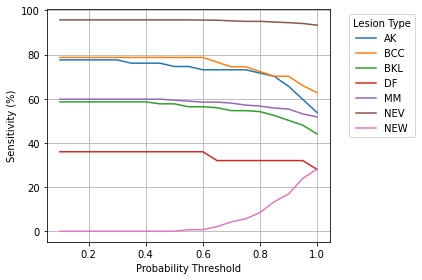

In [ ]:
# Use probability threshold to identify new classes
##############################################################################
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

prob_thresh = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

accuracies = np.zeros(len(prob_thresh))
sensitivity = np.zeros((len(prob_thresh),7))

knn = KNeighborsClassifier(n_neighbors=26, weights='distance',metric='euclidean')
knn.fit(train_set, y_train)
y_pred_knn_probs = knn.predict_proba(test_set_new_class)
y_pred_knn_new_class = knn.predict(test_set_new_class)

for i, val in enumerate(prob_thresh):
  y_pred_prob_thresh = np.zeros(len(test_set_new_class))

  for j, prob in enumerate(y_pred_knn_probs):
    if max(prob)<val:
      y_pred_prob_thresh[j] = num_classes
    else:
      y_pred_prob_thresh[j] = y_pred_knn_new_class[j]

  cm = confusion_matrix(y_new_class,y_pred_prob_thresh)
  FP = cm.sum(axis=0) - np.diag(cm)  
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)
  TPR = TP/(TP+FN)
  sensitivity[i] = TPR
  accuracies[i] = accuracy_score(y_pred_prob_thresh,y_new_class)

SE_plot = pd.DataFrame(sensitivity*100)
SE_plot.columns = ['AK','BCC','BKL','DF','MM','NEV','NEW']
SE_plot['Probability Threshold'] = prob_thresh
SE_plot['Accuracy'] = accuracies*100
prob_plot = SE_plot.plot(x='Probability Threshold',y=['AK','BCC','BKL','DF','MM','NEV','NEW'],kind='line',ylabel='Sensitivity (%)')
plt.grid()
#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',title='Lesion Type')
plt.tight_layout()
plt.show()

##############################################################################

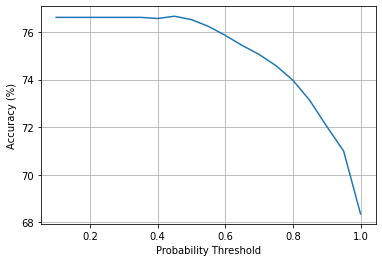

In [ ]:
SE_plot.plot(x='Probability Threshold',y='Accuracy',ylabel='Accuracy (%)').get_legend().remove()
plt.grid()


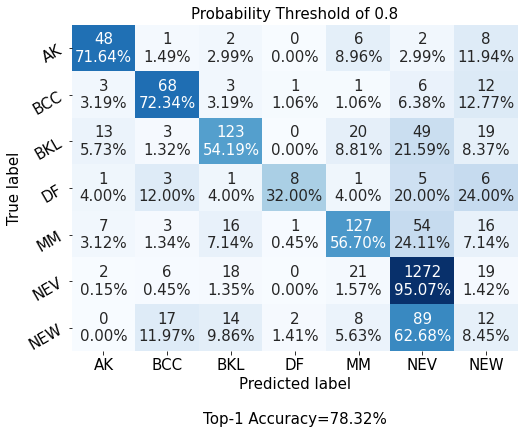

In [ ]:
# Make confusion matrix for specific probability threshold
############################################################################
threshold = 0.8
y_pred_prob_thresh = np.zeros(len(test_set_new_class))

knn = KNeighborsClassifier(n_neighbors=26, weights='distance',metric='euclidean')
knn.fit(train_set, y_train)
y_pred_knn_probs = knn.predict_proba(test_set_new_class)
y_pred_knn_new_class = knn.predict(test_set_new_class)
for j, prob in enumerate(y_pred_knn_probs):
  if max(prob)<threshold:
    y_pred_prob_thresh[j] = num_classes
  else:
    y_pred_prob_thresh[j] = y_pred_knn_new_class[j]

cm = confusion_matrix(y_new_class,y_pred_prob_thresh)
#make_confusion_matrix(cm, figsize=(8,6), cbar=False, include_new=True)
make_confusion_matrix(cm, figsize=(8,6), 
                      cbar=False, 
                      include_new = True, 
                      percent=True, 
                      font_size = 15, 
                      sum_stats=True, 
                      title ="Probability Threshold of "+str(threshold) )

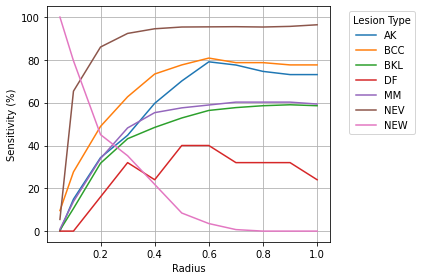

In [ ]:
# Use distance threshold to identify new classes
##############################################################################
from sklearn.neighbors import RadiusNeighborsClassifier

seq = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
accuracies = np.zeros(len(seq))
sensitivity = np.zeros((len(seq),7))

for i, val in enumerate(seq):
  rnc = RadiusNeighborsClassifier(radius=val, weights='distance', outlier_label=num_classes)
  rnc.fit(train_set, y_train)
  y_pred_seq_vasc = rnc.predict(test_set_new_class)
  cm = confusion_matrix(y_new_class,y_pred_seq_vasc)
  FP = cm.sum(axis=0) - np.diag(cm)  
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)
  TPR = TP/(TP+FN)
  sensitivity[i] = TPR
  accuracies[i] = accuracy_score(y_pred_seq_vasc,y_new_class)

SE_plot = pd.DataFrame(sensitivity*100)
SE_plot.columns = ['AK','BCC','BKL','DF','MM','NEV','NEW']
SE_plot['Radius'] = seq
SE_plot['Accuracy'] = accuracies*100
radius_plot = SE_plot.plot(x='Radius',y=['AK','BCC','BKL','DF','MM','NEV','NEW'],kind='line',ylabel='Sensitivity (%)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',title='Lesion Type')
plt.tight_layout()
plt.show()

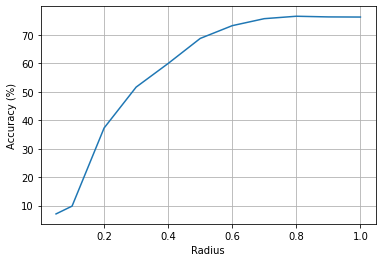

In [ ]:
SE_plot.plot(x='Radius',y='Accuracy',ylabel='Accuracy (%)').get_legend().remove()
plt.grid()


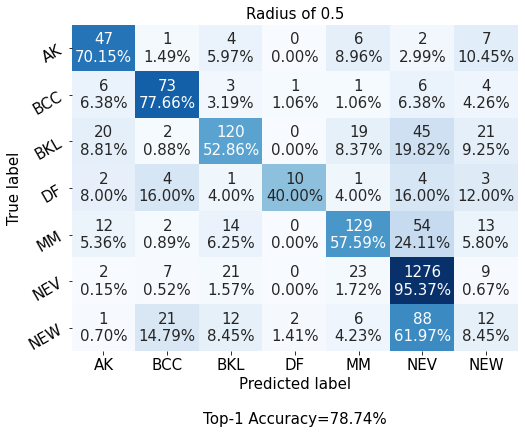

In [ ]:
# Make confusion matrix for specific distance threshold
############################################################################
radius = 0.5
rnc = RadiusNeighborsClassifier(radius=radius, weights='distance', outlier_label=num_classes)
rnc.fit(train_set, y_train)
y_pred_seq_vasc = rnc.predict(test_set_new_class)
cm = confusion_matrix(y_new_class,y_pred_seq_vasc)
make_confusion_matrix(cm, figsize=(8,6), cbar=False, include_new = True, percent=True, font_size = 15, sum_stats=True, title ="Radius of "+str(radius) )
############################################################################

From this repo: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py